# Introduction
Here, we will use Lantern to implement a reverse video search engine. That is, given a video, we will return videos that are "similar" to that video from a collection of video that we index. In this case, we will be considering the "action" displayed in that video as constituting similarity across videos.

The images we will be indexing will be a subset of the [Kinetics dataset](https://www.deepmind.com/open-source/kinetics).

To generate the video embeddings, we will use the [`Omnivore` model](https://towhee.io/action-classification/omnivore), using the `towhee` python library.

If you are running this in a colab, note that enabling a gpu-enabled runtime will be faster when we compute the embeddings. A cpu runtime will take significantly longer.

# Setup Postgres

We install postgres and its dev tools (necessary to build lantern from source). We also start postgres, and set up a user 'postgres' with password 'postgres' and create a database called 'ourdb'




In [ ]:
# We install postgres and its dev tools
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql postgresql-server-dev-all
#  Start postgres
!sudo service postgresql start

# Create user, password, and db
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS ourdb;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE ourdb;'

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 26.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package logrotate.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../00-logrotate_3.19.0-1ubuntu1.1_amd64.deb ...
Unpacking logrotate (3.19.0-1ubuntu1.1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../01-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package python3-yaml.
Preparing to unpack .../02-python3-yaml_5.4.1-1ubuntu1_amd64.deb ...
Unpacking python3-yaml (5.4.1-1ubuntu1) ...
Selecting previous

# Install Lantern and build it from source

In [ ]:
!git clone --recursive https://github.com/lanterndata/lantern.git

Cloning into 'lantern'...
remote: Enumerating objects: 2562, done.
remote: Counting objects: 100% (1342/1342), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 2562 (delta 1068), reused 1003 (delta 922), pack-reused 1220
Receiving objects: 100% (2562/2562), 578.18 KiB | 3.34 MiB/s, done.
Resolving deltas: 100% (1698/1698), done.
Submodule 'third_party/hnswlib' (https://github.com/ngalstyan4/hnswlib) registered for path 'third_party/hnswlib'
Submodule 'third_party/usearch' (https://github.com/ngalstyan4/usearch) registered for path 'third_party/usearch'
Cloning into '/content/lantern/third_party/hnswlib'...
remote: Enumerating objects: 1723, done.        
remote: Counting objects: 100% (333/333), done.        
remote: Compressing objects: 100% (40/40), done.        
remote: Total 1723 (delta 306), reused 293 (delta 293), pack-reused 1390        
Receiving objects: 100% (1723/1723), 530.50 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (1097/1097), done.
Cloning int

In [ ]:
# We build lantern from source
%cd lantern
!mkdir build
%cd build
!pwd
!cmake ..
!make install

/content/lantern
/content/lantern/build
/content/lantern/build
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Build type: 
-- Found pg_config as /usr/bin/pg_config
-- Found postgres binary at /usr/lib/postgresql/14/bin/postgres
-- P

# Installing other Dependencies

In [ ]:
! python -m pip install -q towhee towhee.models pillow ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.0/222.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.8 MB/s eta 0:00:00


### Downloading Video dataset

In [ ]:
!curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_video_search.zip -O
!unzip -q -o reverse_video_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  152M  100  152M    0     0  56.0M      0  0:00:02  0:00:02 --:--:-- 71.3M


We also downloaded the file `reverse_video_search.csv` which contains the id, path, and label of our videos, as seen below:

In [ ]:
import pandas as pd

df = pd.read_csv('./reverse_video_search.csv')

# We'll use this to get a video from an id
id_video = df.set_index('id')['path'].to_dict()
label_ids = {}
for label in set(df['label']):
    label_ids[label] = list(df[df['label']==label].id)

# Visualize the first few rows...
df.head(3)

,id,path,label
0,0,./train/country_line_dancing/bTbC3w_NIvM.mp4,country_line_dancing
1,1,./train/country_line_dancing/n2dWtEmNn5c.mp4,country_line_dancing
2,2,./train/country_line_dancing/zta-Iv-xK7I.mp4,country_line_dancing


# Create Postgres Table

Now let's set up `psycopg2` with postgres, and enable the lantern extension


In [ ]:
import psycopg2

# We use the dbname, user, and password that we specified above
conn = psycopg2.connect(
    dbname="ourdb",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432" # default port for Postgres
)

# Get a new cursor
cursor = conn.cursor()

# Execute the query to load the Lantern extension in
cursor.execute("CREATE EXTENSION IF NOT EXISTS lantern;")

conn.commit()
cursor.close()

Now let's create the table that we will use to store these embeddings. We'll call the table `videos_search`, and it will an integer `id` corresponding to the video's id in the dataset, and the embedding for the video `vector`. Note that we make `vector` of type real array (`real[]`).

In [ ]:
# Create the table
cursor = conn.cursor()

TABLE_NAME = "videos_search"

create_table_query = f"CREATE TABLE {TABLE_NAME} (id integer, vector real[]);"

cursor.execute(create_table_query)

conn.commit()
cursor.close()

# Inserting video embeddings into our database
Now that we have a table created, let's create and insert the embeddings for the videos we have.

Note that the majority of the time spent here is on computing the embeddings for the videos.

Note that the dimensionality of the embeddings we compute is 768, and so this is the dimensionality of the vectors that we will be inserting into our database.

Let's specify the insert pipeline we will use and run it:

In [ ]:
from towhee import pipe, ops
from towhee.datacollection import DataCollection

def read_csv(csv_file):
    import csv
    with open(csv_file, 'r', encoding='utf-8-sig') as f:
        data = csv.DictReader(f)
        for line in data:
            yield line['id'], line['path'], line['label']


cursor = conn.cursor()

def single_insert(id, features):
    vector = [float(x) for x in features]
    cursor.execute(f"INSERT INTO {TABLE_NAME} (id, vector) VALUES (%s, %s);", (id, vector))

insert_pipe = (
    pipe.input('csv_path')
        .flat_map('csv_path', ('id', 'path', 'label'), read_csv)
        .map('id', 'id', lambda x: int(x))
        .map('path', 'frames', ops.video_decode.ffmpeg(sample_type='uniform_temporal_subsample', args={'num_samples': 16}))
        .map('frames', ('labels', 'scores', 'features'), ops.action_classification.omnivore(model_name='omnivore_swinT'))
        .map(('id', 'features'), 'insert_res', single_insert)
        .output()
)

insert_pipe('reverse_video_search.csv')

conn.commit()
cursor.close()







/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://dl.fbaipublicfiles.com/omnivore/models/swinT_checkpoint.torch" to /root/.cache/torch/hub/checkpoints/swinT_checkpoint.torch
100%|██████████| 125M/125M [00:10<00:00, 12.7MB/s]


# Creating an Index
Now that we have inserted the embeddings into our database, we need to construct an index in postgres using lantern. This is important because the index will tell allow postgres to use lantern when performing vector search.

Note that we use L2-squared (squared Euclidean distance) as the distance metric. Also, as a good practice, we specify the dimension of the vectors in the index (although lantern can infer it from the vectors we've already inserted).

In [ ]:
cursor = conn.cursor()

cursor.execute(f"CREATE INDEX ON {TABLE_NAME} USING hnsw (vector dist_l2sq_ops) WITH (dim=768);")

conn.commit()
cursor.close()

# Querying Videos!
Now that we have our index, we can start querying for videos and utilizing vector search.

We define our query pipeline below, and try out a sample query.

In [ ]:
cursor = conn.cursor()

def single_query(features):
    query_vec = str([float(x) for x in features])
    cursor.execute(f"SELECT id FROM {TABLE_NAME} ORDER BY vector <-> ARRAY{query_vec} LIMIT 5;")
    results = cursor.fetchall()
    return results


query_pipe = (
    pipe.input('path')
        .map('path', 'frames', ops.video_decode.ffmpeg(sample_type='uniform_temporal_subsample', args={'num_samples': 16}))
        .map('frames', ('labels', 'scores', 'features'), ops.action_classification.omnivore(model_name='omnivore_swinT'))
        .map('features', 'result', single_query)
        .map('result', 'candidates', lambda x: [id_video[i[0]] for i in x])
        .output('path', 'candidates')
)


# Let's try a sample query
query_path = './test/eating_carrots/ty4UQlowp0c.mp4'

res = DataCollection(query_pipe(query_path))
res.show()


path,candidates
./test/eating_carrots/ty4UQlowp0c.mp4,./train/eating_carrots/9OZhQqMhX50.mp4 ./train/eating_carrots/Ka6z9NtiVMQ.mp4 ./train/eating_carrots/sLQnKz6qv08.mp4 ./train/eating_carrots/bTCznQiu0hc.mp4 ./train/eating_carrots/y1U6Z2ZYQdc.mp4


Let's see what these videos look like:

QUERY VID:


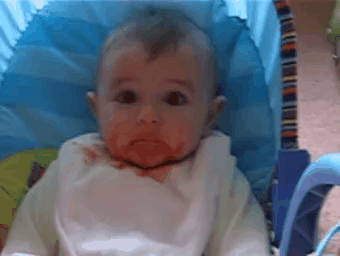

In [ ]:
import os
from IPython import display
from IPython.display import Image as IPImage
from PIL import Image

tmp_dir = './tmp'
os.makedirs(tmp_dir, exist_ok=True)

def video_to_gif(video_path):
    gif_path = os.path.join(tmp_dir, video_path.split('/')[-1][:-4] + '.gif')
    p = (
        pipe.input('path')
            .map('path', 'frames', ops.video_decode.ffmpeg(sample_type='uniform_temporal_subsample', args={'num_samples': 16}))
            .output('frames')
    )
    frames = p(video_path).get()[0]
    imgs = [Image.fromarray(frame) for frame in frames]
    imgs[0].save(fp=gif_path, format='GIF', append_images=imgs[1:], save_all=True, loop=0)
    return gif_path


query_gif = video_to_gif(query_path)

results_paths = []
for path in res[0]['candidates'][:3]:
    gif_path = video_to_gif(path)
    results_paths.append(gif_path)

print("QUERY VID:")
IPImage(filename=query_gif)

SEARCH RESULT 1:


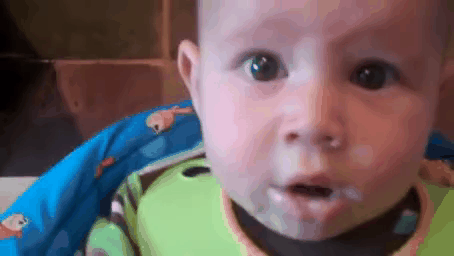

In [ ]:
print("SEARCH RESULT 1:")
IPImage(filename=results_paths[0])

SEARCH RESULT 2:


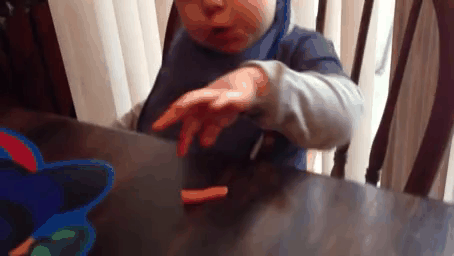

In [ ]:
print("SEARCH RESULT 2:")
IPImage(filename=results_paths[1])

SEARCH RESULT 3:


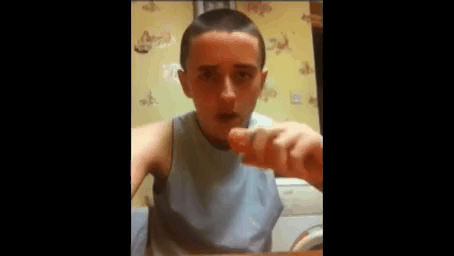

In [ ]:
print("SEARCH RESULT 3:")
IPImage(filename=results_paths[2])

# Conclusion
As we can see, the top 3 videos are all also videos of people eating carrots, which is what our query video was!

And that's how you can implement reverse video search using Lantern and a video embedding model.




### Cleanup

In [ ]:
# Close the postgres connection
conn.close()